In [2]:
import sys
import os

# Add the src directory to the Python path
src_path = os.path.join(os.getcwd(), 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

In [3]:
import numpy as np
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
from src.optimizers import *
from src.activation_functions import * 
from src.utils import *
from src.model_regularization import *
from src.layer import *
from src.batch_normalization import *
np.random.seed(0)


#### Data pre-processing for CUP DATASET 

In [11]:
filepath = "../ML_project/data/cup/ML-CUP24-TR.csv"
df = pd.read_csv(filepath, skiprows=7, header=None)
df.columns = ["ID"] + [f'input_{i}' for i in range(12)] + ['target_x', 'target_y', 'target_z']
df = df.drop('ID', axis=1)
X_train, X_validation, y_train, y_validation = train_test_split(df, train_percent=80, target=['target_x', 'target_y', 'target_z'])
X_train = normalize(data=X_train, type='z-score')
X_validation = normalize(data=X_validation, type='z-score')


In [12]:
filepath = "../ML_project/data/cup/ML-CUP24-TS.csv"
df = pd.read_csv(filepath, skiprows=7, header=None)
df.columns = ["ID"] + [f'input_{i}' for i in range(12)]
df = df.drop('ID', axis=1)
X_test = df.iloc[:, :12]  
X_test = normalize(data=X_test, type='z-score')
print("X_test.shape: ", X_test.shape)

X_test.shape:  (500, 12)


In [15]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of the resulting datasets
print("Training Features Shape:", X_train.shape)
print("Validation Features Shape:", X_validation.shape)
print("Training Target Shape:", y_train.shape)
print("Validation Target Shape:", y_validation.shape)

Training Features Shape: (200, 12)
Validation Features Shape: (50, 12)
Training Target Shape: (200, 3)
Validation Target Shape: (50, 3)


In [16]:
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [7]:
class NN:
    def __init__(self, l1, l2, input_size, hidden_sizes, output_size, 
                 hidden_activations=None, dropout_rates=None, 
                 use_batch_norm=None, output_activation=Activation_Sigmoid()):
        self.layers = []
        prev_size = input_size

        # Default activations to ReLU
        if hidden_activations is None:
            hidden_activations = [Activation_ReLU() for _ in hidden_sizes]

        # Default dropout rates to 0
        if dropout_rates is None:
            dropout_rates = [0.0] * len(hidden_sizes)

        # Default batch_norm to False for all layers
        if use_batch_norm is None:
            use_batch_norm = [False] * len(hidden_sizes)
        else:
            assert len(use_batch_norm) == len(hidden_sizes), \
                "use_batch_norm must have the same length as hidden_sizes"

        # Create hidden layers
        for size, activation, rate, bn_flag in zip(hidden_sizes, hidden_activations, 
                                                 dropout_rates, use_batch_norm):
            # Add dense layer
            self.layers.append(Layer_Dense(prev_size, size, l1=l1, l2=l2))
            
            # Add batch normalization if specified
            if bn_flag:
                self.layers.append(BatchNormalization())
            
            # Add activation
            self.layers.append(activation())
            
            # Add dropout if rate > 0
            if rate > 0:
                self.layers.append(Dropout(rate))
            
            prev_size = size

        # Output layer
        self.layers.append(Layer_Dense(prev_size, output_size))
        # self.layers.append(output_activation)

    def forward(self, inputs, training=True):
        for layer in self.layers:
            # Pass training flag to relevant layers
            if isinstance(layer, (Dropout, BatchNormalization)):
                layer.forward(inputs, training=training)
            else:
                layer.forward(inputs)
            inputs = layer.output
        self.output = inputs
        return self.output

In [8]:
class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss

class Loss_CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)

        if len(y_true.shape) == 1:
            correct_confidence = y_pred_clipped[range(samples), y_true]

        elif len(y_true.shape) == 2:
            correct_confidence = np.sum(y_pred_clipped * y_true, axis=1) 

        negative_log_likelihoods = np.log(correct_confidence)
        return negative_log_likelihoods

    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples


class Activation_Softmax_Loss_CategoricalCrossentropy():

    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()


    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)

        # Set the output
        self.output = self.activation.output

        return self.loss.calculate(self.output, y_true)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)

        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        self.dinputs = dvalues.copy()

        self.dinputs[range(samples), y_true] -= 1

        self.dinputs = self.dinputs / samples

class MSE:
    def __init__(self):
        self.dinputs = 0
        self.loss = 0
        self.output = 0
        
        
    def forward(self, y_pred, y_true):
        self.output = np.mean((y_pred - y_true)**2)
        return self.output
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        
        self.dinputs = -2 * (y_true - dvalues) / outputs
        self.dinputs = self.dinputs / samples
        
class MEE:
    def __init__(self):
        self.dinputs = 0
        self.loss = 0
        self.output = 0
    
    def forward(self, y_pred, y_true):
        self.output = np.mean(np.sqrt(np.sum((y_pred - y_true)**2, axis=1)))
        return self.output
    
    def backward(self, dvalues, y_true):
        # Number of samples and outputs
        samples = len(dvalues)
        outputs = len(dvalues[0])

        differences = dvalues - y_true
        euclidean_distances = np.sqrt(np.sum(differences**2, axis=1, keepdims=True))
        
        # Avoid division by zero
        euclidean_distances = np.maximum(euclidean_distances, 1e-7)

        self.dinputs = differences / euclidean_distances
        
        # Normalize by number of samples and outputs
        self.dinputs = self.dinputs / (samples * outputs)
        
        return self.dinputs

In [9]:
param_grid = {
    'learning_rate': [0.001, 0.01],
    'l1': [0.0, 0.01],
    'l2': [0.0, 0.01],
    'dropout_rate': [0.0, 0.3],
    'batch_size': [32],
    'n_epochs': [100],
    'hidden_sizes': [[12, 10]],
    'activations': [Activation_ReLU, Activation_Leaky_ReLU]
}

# Generate parameter combinations
keys = param_grid.keys()
values = param_grid.values()
param_combinations = [dict(zip(keys, combo)) for combo in itertools.product(*values)]

In [ ]:
# X = X.values if isinstance(X, pd.DataFrame) else X
# y = y.values if isinstance(y, (pd.Series, pd.DataFrame)) else y

In [45]:
model = NN(l1=0.0001,
    l2=0.000001,
    input_size=12,
    hidden_sizes=[32, 16, 8],
    output_size=3,
    hidden_activations=[Activation_ReLU, Activation_Leaky_ReLU, Activation_ReLU, Activation_Leaky_ReLU],
    dropout_rates=[0.2, 0.1], 
    use_batch_norm=[True,True, True],
)

batch_size = 10000
learning_rate = 0.001
n_epochs = 1000

In [ ]:
optimizer = Optimizer_Adam(learning_rate=learning_rate, decay=1e-4, epsilon=1e-7)
loss_function = MSE()
train_losses = []
validation_losses = []
# Training loop
for epoch in range(n_epochs):
    batch_losses = []
    for X_batch, y_batch in create_batches(X_train, y_train, batch_size):
        # Convert to numpy if using pandas
        if isinstance(X_batch, pd.DataFrame):
            X_batch = X_batch.values
        if isinstance(y_batch, (pd.Series, pd.DataFrame)):
            y_batch = y_batch.values
        
        # Forward pass
        model.forward(X_batch, training=True)
        loss = loss_function.forward(model.output, y_batch)
        
        # Backward pass
        loss_function.backward(model.output, y_batch)
        dvalues = loss_function.dinputs
        
        # Gradient propagation
        for layer in reversed(model.layers):
            if hasattr(layer, 'backward'):
                layer.backward(dvalues)
                dvalues = layer.dinputs
                if isinstance(dvalues, pd.DataFrame):
                    dvalues = dvalues.values
        
        # Update parameters
        optimizer.pre_update_params()
        for layer in model.layers:
            if isinstance(layer, Layer_Dense):
                optimizer.update_params(layer)
        optimizer.post_update_params()
        current_lr = optimizer.current_learning_rate
        print(f"Epoch {epoch} LR: {current_lr:.6f}")
        grad_magnitudes = []
        for layer in model.layers:
            if isinstance(layer, Layer_Dense):
                grad_norm = np.linalg.norm(layer.dweights)
                grad_magnitudes.append(grad_norm)
        print(f"Gradient norms: {grad_magnitudes}")
        batch_losses.append(loss)
    epoch_loss = np.mean(batch_losses)
    print(epoch_loss)
    train_losses.append(epoch_loss)
    
    # Validation
    model.forward(X_validation, training=False)
    val_mee = loss_function.forward(model.output, y_validation)
    print(f"Validation MSE: {val_mee:.4f}")
    validation_losses.append(val_mee)


Epoch 0 LR: 0.001000
Gradient norms: [3.6264056030837946, 3.540756607943742, 5.4004822975800275]
61.028810551574615
Validation MSE: 62.0369
Epoch 1 LR: 0.001000
Gradient norms: [3.3952792745646936, 4.066080480655644, 5.3782690552008425]
61.24009156805011
Validation MSE: 61.7280
Epoch 2 LR: 0.001000
Gradient norms: [4.332386104612545, 4.156168182100171, 4.525472181318665]
60.65972582815573
Validation MSE: 61.3986
Epoch 3 LR: 0.001000
Gradient norms: [3.0307716373670868, 3.512478261137978, 5.130676753375184]
60.815408608211584
Validation MSE: 61.1326
Epoch 4 LR: 0.001000
Gradient norms: [4.07885908395999, 3.617694082078415, 5.137195737404804]
60.44323142859516
Validation MSE: 60.8598
Epoch 5 LR: 0.001000
Gradient norms: [3.411669127900686, 3.95240718230675, 5.238944089613115]
60.28894083447197
Validation MSE: 60.5962
Epoch 6 LR: 0.000999
Gradient norms: [3.643551628852192, 3.6240371790422214, 5.320600922807165]
59.582499205721476
Validation MSE: 60.3846
Epoch 7 LR: 0.000999
Gradient norm

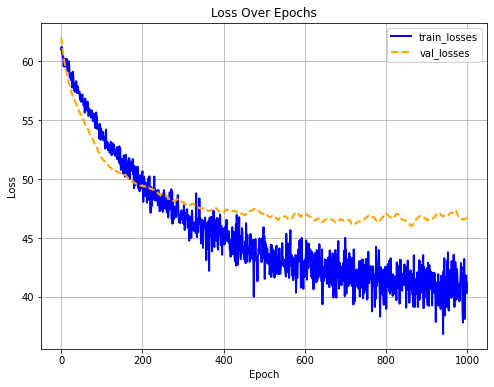

In [47]:
plot_losses(train_losses, validation_losses)

In [15]:
test_accuracy = []
print(X_test.shape)
# Forward pass

# loss = loss_activation.forward(dense2.output, y_test)
print(loss_function.output.shape)
# Calculate accuracy for this batch
predictions = loss_function.output
# if len(y_test.shape) == 2:
#     y_true = np.argmax(y_batch, axis=1)
# else:
#     y_true = y_test
# accuracy = np.mean(predictions == y_true)
# test_accuracy.append(accuracy)

(50, 12)
()


In [16]:
predictions

49.3117179846313

In [ ]:
# best_params = None
# best_mse = float('inf')


# for params in param_combinations:
#     print(f"\nTesting parameters: {params}")
#     fold_val_mses = []
    
#     # K-Fold Cross Validation
#     n_splits = 5
#     indices = np.random.RandomState(seed=42).permutation(len(X))
#     fold_sizes = (len(X) // n_splits) * np.ones(n_splits, dtype=int)
#     fold_sizes[:len(X) % n_splits] += 1
    
#     current = 0
#     for fold in range(n_splits):
#         # Create fold indices
#         start = current
#         end = start + fold_sizes[fold]
#         val_idx = indices[start:end]
#         train_idx = np.concatenate([indices[:start], indices[end:]])
#         current = end

#         # Split data
#         X_train_fold, X_val_fold = X[train_idx], X[val_idx]
#         y_train_fold, y_val_fold = y[train_idx], y[val_idx]

#         # Initialize model with current parameters
#         model = NN(
#             input_size=X.shape[1],
#             hidden_sizes=params['hidden_sizes'],
#             output_size=3,
#             hidden_activations=[params['activations']()],
#             dropout_rates=[params['dropout_rate']] * len(params['hidden_sizes']),
#             l1=params['l1'],
#             l2=params['l2']
#         )
#         optimizer = Optimizer_Adam(learning_rate=params['learning_rate'])
#         loss_function = MSE()

#         # Training loop
#         for epoch in range(params['n_epochs']):
#             # Mini-batch training
#             batch_losses = []
#             for X_batch, y_batch in create_batches(X_train_fold, y_train_fold, params['batch_size']):
#                 # Convert to numpy if using pandas
#                 if isinstance(X_batch, pd.DataFrame):
#                     X_batch = X_batch.values
#                 if isinstance(y_batch, (pd.Series, pd.DataFrame)):
#                     y_batch = y_batch.values
                
#                 # Forward pass
#                 model.forward(X_batch, training=True)
#                 loss = loss_function.forward(model.output, y_batch)
                
#                 # Backward pass
#                 loss_function.backward(model.output, y_batch)
#                 dvalues = loss_function.dinputs
                
#                 # Gradient propagation
#                 for layer in reversed(model.layers):
#                     if hasattr(layer, 'backward'):
#                         layer.backward(dvalues)
#                         dvalues = layer.dinputs
#                         # Convert to numpy if needed
#                         if isinstance(dvalues, pd.DataFrame):
#                             dvalues = dvalues.values
                
#                 # Update parameters
#                 optimizer.pre_update_params()
#                 for layer in model.layers:
#                     if isinstance(layer, Layer_Dense):
#                         optimizer.update_params(layer)
#                 optimizer.post_update_params()
                
#                 batch_losses.append(loss)

#             # Validation
#             model.forward(X_val_fold, training=False)
#             val_loss = loss_function.forward(model.output, y_val_fold)
        
#         fold_val_mses.append(val_loss)
#         print(f"Fold {fold+1} Val MSE: {val_loss:.4f}")

#     # Calculate average performance
#     avg_val_mse = np.mean(fold_val_mses)
#     print(f"Average Validation MSE: {avg_val_mse:.4f}")
    
#     # Update best parameters
#     if avg_val_mse < best_mse:
#         best_mse = avg_val_mse
#         best_params = params

# print("\n=== Best Parameters ===")
# print(best_params)
# print(f"Best Validation MSE: {best_mse:.4f}")